# ITransformer

The idea behind iTransformer comes from the realization that the vanilla Transformer model uses `temporal tokens`.

This means that the model looks at all features at a single time step. Thus, it is `challenging for the model to learn temporal dependencies` when looking at one time step at a time.

A solution to that problem is patching, which was proposed with the PatchTST model. With patching, we simply group time points together before tokenizing and embedding them, as shown below.

<img style="width: 400px;" src="https://miro.medium.com/v2/resize:fit:828/format:webp/0*s-jwxIc6eVJuljz9.png">

In iTransformer, we push patching to the extreme by simply applying the model on the inverted dimensions.

<img style="width: 600px;" src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*tIHD9oZKtK6TWyI_Ep6V_w.png">

## Architecture

The iTransformer employs the vanilla encoder-decoder architecture with the embedding, projection and Transformer blocks, as originally proposed in the seminal paper Attention Is All You Need in 2017. 

<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*1XBPMSERvZohQoVUsp7LZQ.png" style="width: 700px;"/>



### Embedding layer

First, the input series are independently embedded as tokens. Again, this is like an extreme case of patching, where instead of tokenizing subsequences of the input, the model tokenizes the entire input sequence.

### Multivariate attention

Then, the embeddings are sent to the attention layer, where it will learn a multivariate correlation map.

This is possible because the inverted model sees each feature as an independent process. As a result, the attention mechanism learns correlations between pairs of features, making iTransformer especially suitable for multivariate forecasting tasks.

In [1]:
# For Mac compatibility
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasetsforecast.long_horizon import LongHorizon

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, PatchTST, iTransformer, TSMixer

In [4]:
def load_data(name):
    if name == "ettm1":
        Y_df, *_ = LongHorizon.load(directory='./', group='ETTm1')
        Y_df = Y_df[Y_df['unique_id'] == 'OT']
        Y_df['ds'] = pd.to_datetime(Y_df['ds'])
        val_size = 11520
        test_size = 11520
        freq = '15T'
    elif name == "ettm2":
        Y_df, *_ = LongHorizon.load(directory='./', group='ETTm2')
        Y_df = Y_df[Y_df['unique_id'] == 'OT']
        Y_df['ds'] = pd.to_datetime(Y_df['ds'])
        val_size = 11520
        test_size = 11520
        freq = '15T'
    elif name == 'etth1':
        Y_df, *_ = LongHorizon.load(directory='./', group='ETTh1')
        Y_df['ds'] = pd.to_datetime(Y_df['ds'])
        val_size = 2880
        test_size = 2880
        freq = 'H'
    elif name == "etth2":
        Y_df, *_ = LongHorizon.load(directory='./', group='ETTh2')
        Y_df['ds'] = pd.to_datetime(Y_df['ds'])
        val_size = 2880
        test_size = 2880
        freq = 'H'

    return Y_df, val_size, test_size, freq

In [5]:
from utilsforecast.losses import mae, mse
from utilsforecast.evaluation import evaluate

Y_df, val_size, test_size, freq = load_data('ettm1')

horizon = 96

models = [
    iTransformer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3),
    TSMixer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3),
    NHITS(h=horizon, input_size=3*horizon, max_steps=1000, early_stop_patience_steps=3),
    PatchTST(h=horizon, input_size=3*horizon, max_steps=1000, early_stop_patience_steps=3)
]

nf = NeuralForecast(models=models, freq=freq)
nf_preds = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None)
nf_preds = nf_preds.reset_index()

ettm1_evaluation = evaluate(df=nf_preds, metrics=[mae, mse], models=['iTransformer', 'TSMixer', 'NHITS', 'PatchTST'])
ettm1_evaluation.to_csv('ettm1_results.csv', index=False, header=True)

/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params
---------------------------------------------------------
0 | los

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Use

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                     | Params
-----------------------------------------------------------
0 | loss          | MAE                      | 0     
1 | padder        | ConstantPad1d            | 0     
2 | scaler        | TemporalNorm             | 0     
3 | norm          | ReversibleInstanceNorm1d | 2     
4 | mixing_layers | Sequential               | 169 K 
5 | out           | Linear                   | 27.7 K
-----------------------------------------------------------
196 K     Trainable params
0         Non-trainable params
196 K     Total params
0.788     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 3.2 M 
-----------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.759    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/torch/nn/functional.py:4024: UserWarning: The operator 'aten::upsample_linear1d.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.upsample_linear1d(input, output_size, align_corners, scale_factors)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params
---------------------------------------------------
0 | loss         | MAE               | 0     
1 | padder_train | ConstantPad1d     | 0     
2 | scaler       | TemporalNorm      | 0     
3 | model        | PatchTST_backbone | 846 K 
---------------------------------------------------
846 K     Trainable params
3         Non-trainable params
846 K     Total params
3.387     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/neuralforecast/core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [6]:
Y_df, val_size, test_size, freq = load_data('ettm2')

horizon = 96

models = [
    iTransformer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3),
    TSMixer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3),
    NHITS(h=horizon, input_size=3*horizon, max_steps=1000, early_stop_patience_steps=3),
    PatchTST(h=horizon, input_size=3*horizon, max_steps=1000, early_stop_patience_steps=3)
]

nf = NeuralForecast(models=models, freq=freq)
nf_preds = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None)
nf_preds = nf_preds.reset_index()

ettm2_evaluation = evaluate(df=nf_preds, metrics=[mae, mse], models=['iTransformer', 'TSMixer', 'NHITS', 'PatchTST'])
ettm2_evaluation.to_csv('ettm2_results.csv', index=False, header=True)

/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params
---------------------------------------------------------
0 | los

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                     | Params
-----------------------------------------------------------
0 | loss          | MAE                      | 0     
1 | padder        | ConstantPad1d            | 0     
2 | scaler        | TemporalNorm             | 0     
3 | norm          | ReversibleInstanceNorm1d | 2     
4 | mixing_layers | Sequential               | 169 K 
5 | out           | Linear                   | 27.7 K
-----------------------------------------------------------
196 K     Trainable params
0         Non-trainable params
196 K     Total params
0.788     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 3.2 M 
-----------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.759    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params
---------------------------------------------------
0 | loss         | MAE               | 0     
1 | padder_train | ConstantPad1d     | 0     
2 | scaler       | TemporalNorm      | 0     
3 | model        | PatchTST_backbone | 846 K 
---------------------------------------------------
846 K     Trainable params
3         Non-trainable params
846 K     Total params
3.387     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/neuralforecast/core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [7]:
Y_df, val_size, test_size, freq = load_data('etth1')

horizon = 96

models = [
    iTransformer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3),
    TSMixer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3),
    NHITS(h=horizon, input_size=3*horizon, max_steps=1000, early_stop_patience_steps=3),
    PatchTST(h=horizon, input_size=3*horizon, max_steps=1000, early_stop_patience_steps=3)
]

nf = NeuralForecast(models=models, freq=freq)
nf_preds = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None)
nf_preds = nf_preds.reset_index()

etth1 = evaluate(df=nf_preds, metrics=[mae, mse], models=['iTransformer', 'TSMixer', 'NHITS', 'PatchTST'])
etth1.to_csv('etth1_results.csv', index=False, header=True)

/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params
---------------------------------------------------------
0 | los

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                     | Params
-----------------------------------------------------------
0 | loss          | MAE                      | 0     
1 | padder        | ConstantPad1d            | 0     
2 | scaler        | TemporalNorm             | 0     
3 | norm          | ReversibleInstanceNorm1d | 2     
4 | mixing_layers | Sequential               | 169 K 
5 | out           | Linear                   | 27.7 K
-----------------------------------------------------------
196 K     Trainable params
0         Non-trainable params
196 K     Total params
0.788     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 3.2 M 
-----------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.759    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params
---------------------------------------------------
0 | loss         | MAE               | 0     
1 | padder_train | ConstantPad1d     | 0     
2 | scaler       | TemporalNorm      | 0     
3 | model        | PatchTST_backbone | 846 K 
---------------------------------------------------
846 K     Trainable params
3         Non-trainable params
846 K     Total params
3.387     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/neuralforecast/core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [8]:
Y_df, val_size, test_size, freq = load_data('etth2')

horizon = 96

models = [
    iTransformer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3),
    TSMixer(h=horizon, input_size=3*horizon, n_series=1, max_steps=1000, early_stop_patience_steps=3),
    NHITS(h=horizon, input_size=3*horizon, max_steps=1000, early_stop_patience_steps=3),
    PatchTST(h=horizon, input_size=3*horizon, max_steps=1000, early_stop_patience_steps=3)
]

nf = NeuralForecast(models=models, freq=freq)
nf_preds = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None)
nf_preds = nf_preds.reset_index()

etth2 = evaluate(df=nf_preds, metrics=[mae, mse], models=['iTransformer', 'TSMixer', 'NHITS', 'PatchTST'])
etth2.to_csv('etth2_results.csv', index=False, header=True)

/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params
---------------------------------------------------------
0 | los

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                     | Params
-----------------------------------------------------------
0 | loss          | MAE                      | 0     
1 | padder        | ConstantPad1d            | 0     
2 | scaler        | TemporalNorm             | 0     
3 | norm          | ReversibleInstanceNorm1d | 2     
4 | mixing_layers | Sequential               | 169 K 
5 | out           | Linear                   | 27.7 K
-----------------------------------------------------------
196 K     Trainable params
0         Non-trainable params
196 K     Total params
0.788     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 3.2 M 
-----------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.759    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params
---------------------------------------------------
0 | loss         | MAE               | 0     
1 | padder_train | ConstantPad1d     | 0     
2 | scaler       | TemporalNorm      | 0     
3 | model        | PatchTST_backbone | 846 K 
---------------------------------------------------
846 K     Trainable params
3         Non-trainable params
846 K     Total params
3.387     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/neuralforecast/core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [9]:
files = ['etth1_results.csv', 'etth2_results.csv', 'ettm1_results.csv', 'ettm2_results.csv']
datasets = ['etth1', 'etth2', 'ettm1', 'ettm2']

dataframes = []

for file, dataset in zip(files, datasets):
    df = pd.read_csv(file)
    df['dataset'] = dataset

    dataframes.append(df)

full_df = pd.concat(dataframes, ignore_index=True)
full_df = full_df.drop(['unique_id'], axis=1)
full_df

,metric,iTransformer,TSMixer,NHITS,PatchTST,dataset
0,mae,0.193873,0.178388,0.250795,0.179944,etth1
1,mse,0.063236,0.054583,0.105660,0.056111,etth1
2,mae,0.296325,0.285308,0.300355,0.279003,etth2
3,mse,0.143894,0.135130,0.149402,0.129093,etth2
4,mae,0.130223,0.123234,0.236398,0.121248,ettm1
5,mse,0.029582,0.027118,0.092705,0.026530,ettm1
6,mae,0.202297,0.188140,0.209011,0.178029,ettm2
7,mse,0.073085,0.066470,0.081491,0.062765,ettm2


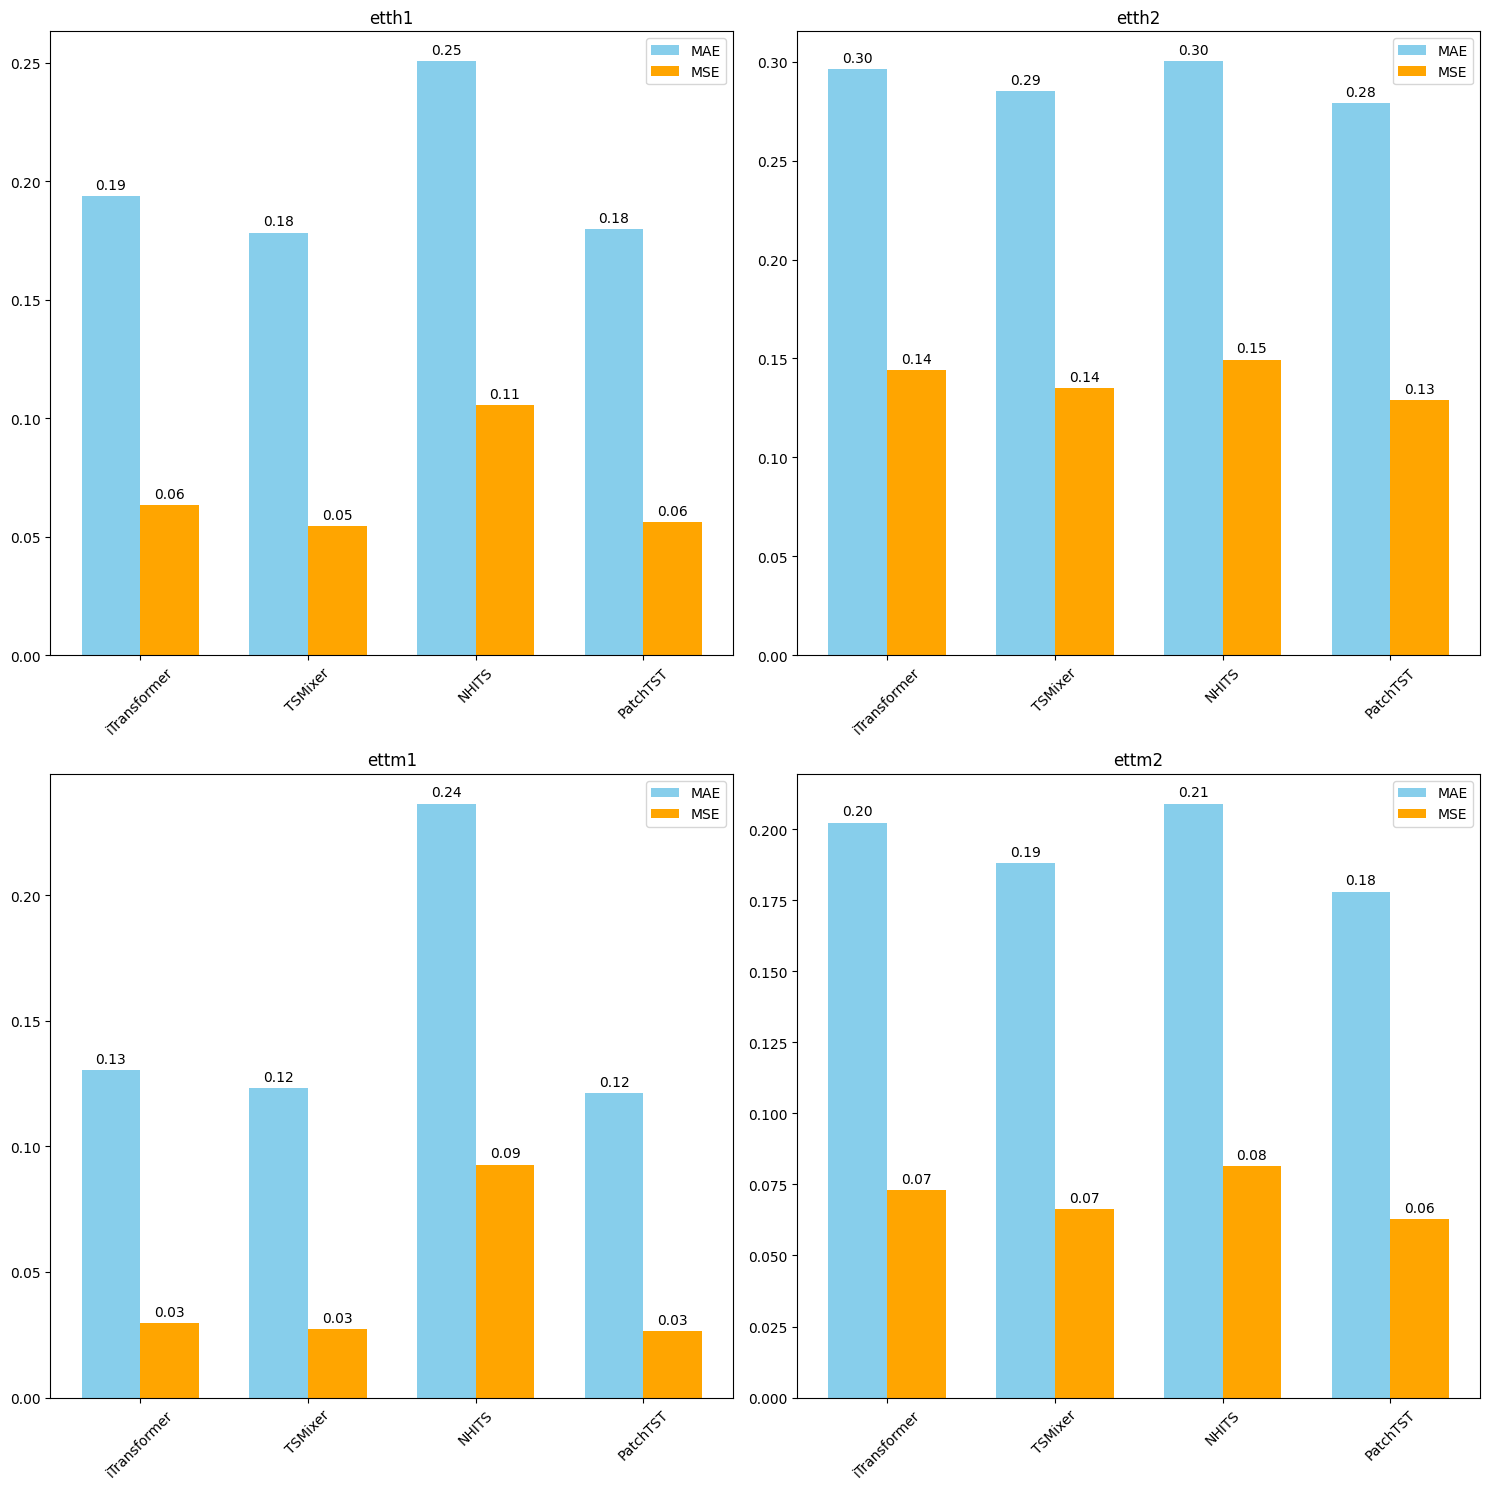

In [10]:
import matplotlib.pyplot as plt
import numpy as np

dataset_names = full_df['dataset'].unique()
model_names = ['iTransformer', 'TSMixer', 'NHITS', 'PatchTST']

fig, axs = plt.subplots(2, 2, figsize=(15, 15)) 
bar_width = 0.35  

axs = axs.flatten()

for i, dataset_name in enumerate(dataset_names):
    df_subset = full_df[(full_df['dataset'] == dataset_name) & (full_df['metric'] == 'mae')]
    mae_vals = df_subset[model_names].values.flatten()
    df_subset = full_df[(full_df['dataset'] == dataset_name) & (full_df['metric'] == 'mse')]
    mse_vals = df_subset[model_names].values.flatten()
    
    indices = np.arange(len(model_names))
    
    bars_mae = axs[i].bar(indices - bar_width / 2, mae_vals, bar_width, color='skyblue', label='MAE')
    bars_mse = axs[i].bar(indices + bar_width / 2, mse_vals, bar_width, color='orange', label='MSE')
    
    for bars in [bars_mae, bars_mse]:
        for bar in bars:
            height = bar.get_height()
            axs[i].annotate(f'{height:.2f}', 
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')
    
    axs[i].set_xticks(indices)
    axs[i].set_xticklabels(model_names, rotation=45)
    axs[i].set_title(dataset_name)
    axs[i].legend(loc='best')

plt.tight_layout()

plt.savefig('model_performance_plots.png')